In [30]:

from GeneralBacktest import Backtest,Position,Bid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf
import pickle
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import statistics

In [2]:
#data = get_data(tickers,'1440d','1d')
data = pd.read_csv("test_data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)

In [40]:
l = [i for i in range(10)]
np.percentile(l,80)

7.2

In [41]:
class EXP3:
    def __init__(self,data,gamma):
        self.data = data.pct_change()
        self.tickers = self.data.columns
        self.data.columns = [i for i in range(len(self.tickers))]
        self.num_actions = len(self.data.columns)
        self.gamma = gamma
        self.weights = [1]*self.num_actions
        
        self.ProbabilityDistr = pd.DataFrame(columns = self.tickers)
        
    
        
        self.regrets = []
        self.current_hold = -1
        self.rewards = []

    #get current distribution
    def get_distr(self):        
        theSum = float(sum(self.weights))
        return tuple((1.0 - self.gamma) * (w / theSum) + (self.gamma / len(self.weights)) for w in self.weights)
    
    
    #draw an action from distribution
    def draw(self,weights):
        choice = random.uniform(0, sum(weights))
        choiceIndex = 0
        for weight in weights:
            choice -= weight
            if choice <= 0:
                return choiceIndex
            choiceIndex += 1
    
    def reset(self):
        self.rewards = []
        self.weights = [1]*self.num_actions
    
    
    def buy(self):
        buy_ticker = []
        ProbabilityDistribution = self.get_distr()
        #take another action
        choice = self.draw(ProbabilityDistribution)
        self.current_hold = choice
        
        self.ProbabilityDistr.loc[len(self.ProbabilityDistr)] = ProbabilityDistribution
        cutoff = np.percentile(ProbabilityDistribution, 90)
        for i in range(len(self.tickers)):
            if ProbabilityDistribution[i] > cutoff:
                buy_ticker.append(self.tickers[i])
        return buy_ticker
        
        
    def predict(self,ti,df,positions,cash,full_data):
        bid_list = []
        
        #sell the previous one
        for pos in positions.values():
            ticker = pos.ticker
            price = df.iloc[-1][pos.ticker]
            shares_held = pos.shares
            
            bid = Bid(ticker = ticker,shares = shares_held,price = price,bid_type = 0)
            bid_list.append(bid)
            
            cash += shares_held*price
        
        #update reward
        if self.current_hold !=-1:
            reward = self.data.loc[ti,self.current_hold]

            #scaled_reward
            min_ret = min(self.data.loc[ti])
            max_ret = max(self.data.loc[ti])
            mean_ret = sum(self.data.loc[ti])/len(self.data.loc[ti])

            scaled_reward = (reward-mean_ret)/(max_ret-min_ret)


            estimatedReward = 1.0 * scaled_reward / self.ProbabilityDistr.iloc[-1][self.current_hold]
            self.weights[self.current_hold] *= np.exp(estimatedReward * self.gamma / self.num_actions)
        

        
        targets = self.buy()
        if len(targets) == 0:
            return bid_list
        print(len(targets))
        amount = cash / len(targets)
        for ticker in targets:
            price = df.iloc[-1][ticker]
            shares = amount//price
            bid = Bid(ticker = ticker,shares = shares,price = price,bid_type = 1)
            bid_list.append(bid)

        return bid_list


In [51]:
exp3 = EXP3(data,0.9)
exp3_bt = Backtest(data,exp3)
exp3_bt.backtest_full()

====================Start====================
1
2
3
3
3
4
4
5
5
5
6
7
8
8
8
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10

<AxesSubplot:>

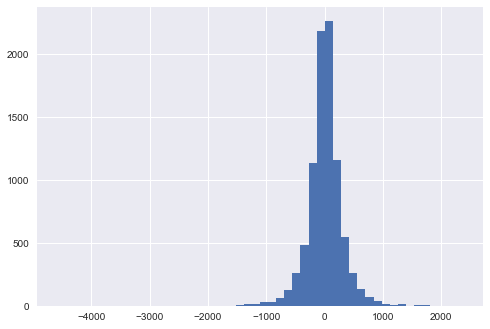

In [52]:
exp3_bt.transaction_history['pnl'][exp3_bt.transaction_history.type == 0].hist(bins = 50)

In [53]:
exp3_bt.transaction_history

,dt,ticker,type,price,shares,amount,transaction_cost,pnl
0,2019-03-21,F,1,7.937467,12598.0,99996.204496,0.0,0.000000
1,2019-03-22,F,0,7.800457,12598.0,98270.157295,0.0,-1726.047201
2,2019-03-22,BMY,1,42.794468,1148.0,49128.049179,0.0,0.000000
3,2019-03-22,F,1,7.800457,6299.0,49135.078648,0.0,0.000000
4,2019-03-25,BMY,0,42.199112,1148.0,48444.580505,0.0,-683.468674
...,...,...,...,...,...,...,...,...
17735,2022-10-07,PEP,0,161.610001,103.0,16645.830063,0.0,0.000000
17736,2022-10-07,RTX,0,84.010002,199.0,16717.990425,0.0,0.000000
17737,2022-10-07,TGT,0,152.339996,110.0,16757.399597,0.0,0.000000
17738,2022-10-07,UPS,0,159.139999,105.0,16709.699936,0.0,0.000000


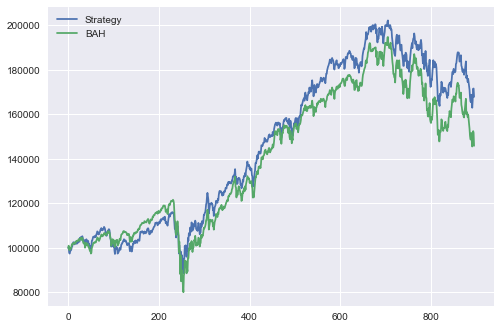

In [54]:
plt.style.use('seaborn')
exp3_bt.plot()

In [12]:
exp3_bt.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2019-03-20,10,10,248.462112,99751.537888,100000.000000,100000.000000
1,2019-03-21,20,10,283.166542,101431.137905,101714.304447,101719.086596
2,2019-03-22,20,10,386.992241,99276.174820,99663.167061,99677.910952
3,2019-03-25,20,10,394.587612,98906.981926,99301.569538,99344.428927
4,2019-03-26,20,10,333.356293,100195.353092,100528.709385,100563.168486
...,...,...,...,...,...,...,...
891,2022-09-30,20,10,505.314453,157752.430428,158257.744881,143946.104325
892,2022-10-03,20,10,374.224449,161231.480476,161605.704926,147381.891988
893,2022-10-04,20,10,386.124474,167004.090843,167390.215317,152370.271558
894,2022-10-05,20,10,519.224518,168098.298943,168617.523460,153187.275279


In [46]:
exp3_bt.upload_to_dashboard("EXP3_90_percentile")

Data uploaded.
